In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from PIL import Image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1385,00007169_003.png,No Finding,3,7169,058Y,F,AP,2500,2048,0.168,0.168
3316,00016410_039.png,Emphysema|Infiltration|Mass|Pneumothorax,39,16410,042Y,F,AP,2500,2048,0.168,0.168
976,00005066_065.png,Cardiomegaly,65,5066,055Y,M,AP,2500,2048,0.168,0.168


In [3]:
## EDA

# Metadata EDA

## Get individual disease labels

In [4]:
all_diseases = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x : x.split('|')))))

for disease in all_diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].apply(lambda x : int(disease in x))

all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
70290,00017324_001.png,No Finding,1,17324,35,F,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
43457,00011212_001.png,No Finding,1,11212,56,F,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
39920,00010430_002.png,No Finding,2,10430,59,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0


In [5]:
# df of only positive pneumonia cases, for handiness
p_xray_df = all_xray_df[all_xray_df['Pneumonia'] == 1]

## Follow up number

Follow up number distribution in pneumonia dataset falls off slower than whole set - subjects in original dataset with no findings less likely to get follow up screening?

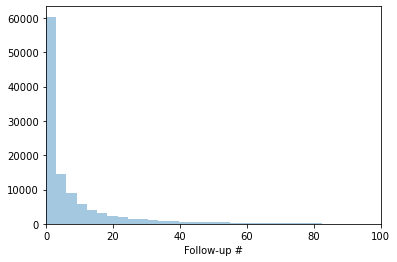

In [6]:
# Whole ds
g = sns.distplot(all_xray_df['Follow-up #'], bins=60, kde=False)
g.axes.set_xlim(0, 100)
plt.show()

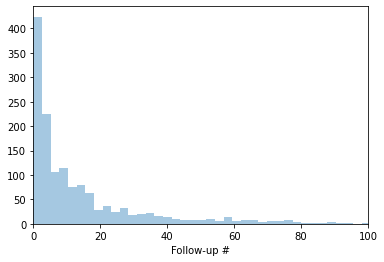

In [7]:
# Pneumonia only
g = sns.distplot(p_xray_df['Follow-up #'], bins=60, kde=False)
g.axes.set_xlim(0, 100)
plt.show()

## Diseases per patient

Exponential fall off in distribution of diseases per patient which one would expect if they're mostly independent. However subjects who have a positive case of pneumonia at some point in time are likely to have another disease at some point as well in this dataset (possibly since pneumonia can be a result of these diseases?). There are also a sizable fraction (about 22%) of pneumonia images which come from patients that appear more than once in the dataset - should try and prevent patients which appear in the training set from also appearing in the data set as the model is unlikely to see patients it has already trained on in a real scenario.

In [8]:
# Get distrib of num. of unique diseases per unique patient
all_xray_df['Disease List'] = all_xray_df['Finding Labels'].apply(lambda x : x.split('|'))

num_diseases = []
for i, group in all_xray_df.groupby('Patient ID'):
    patient_diseases = np.unique(group['Disease List'].sum())
    num_diseases += [len(patient_diseases) - int('No Finding' in patient_diseases)]

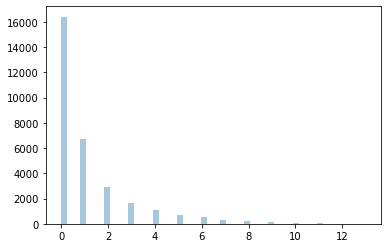

In [9]:
sns.distplot(num_diseases, kde=False)

In [10]:
# Repeat for only pneumonia
p_xray_df['Disease List'] = p_xray_df['Finding Labels'].apply(lambda x : x.split('|'))

p_num_diseases = []
for i, group in p_xray_df.groupby('Patient ID'):
    patient_diseases = np.unique(group['Disease List'].sum())
    p_num_diseases += [len(patient_diseases) - int('No Finding' in patient_diseases)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


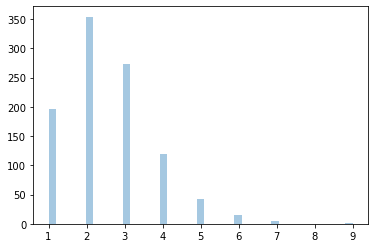

In [11]:
sns.distplot(p_num_diseases, kde=False)

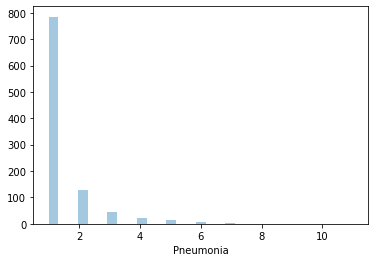

In [12]:
# Get number of pneumonia-positive images for each individual patient ID
p_repeats = p_xray_df.groupby('Patient ID')['Pneumonia'].count()
sns.distplot(p_repeats, kde=False)

## Pneumonia vs non-pneumonia

Pneumonia cases make up about 1.3% of all images in dataset.

In [13]:
len(p_xray_df) / len(all_xray_df)

0.012763110952550838

## Gender
Gender bias toward men in whole dataset and even moreso among pneumonia cases

In [14]:
# Whole ds
all_xray_df['Patient Gender'].value_counts()

M    63340
F    48780
Name: Patient Gender, dtype: int64

In [15]:
# Pneumonia only
p_xray_df['Patient Gender'].value_counts()

M    838
F    593
Name: Patient Gender, dtype: int64

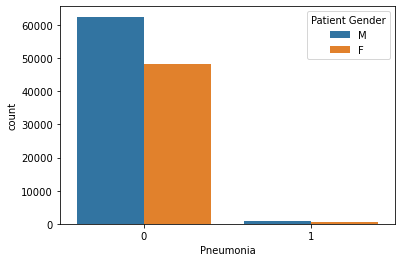

In [16]:
sns.countplot('Pneumonia', hue='Patient Gender', data=all_xray_df)

## Age
Not many pneumonia samples below 20 or above 70 in the pneumonia population. Overall skew towards 20-65 age range in both pneumonia and total populations.

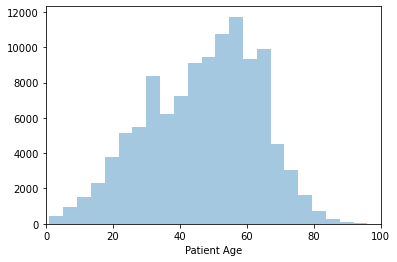

In [17]:
# Whole ds
g = sns.distplot(all_xray_df['Patient Age'], bins=100, kde=False)
g.axes.set_xlim(0, 100)
plt.show()

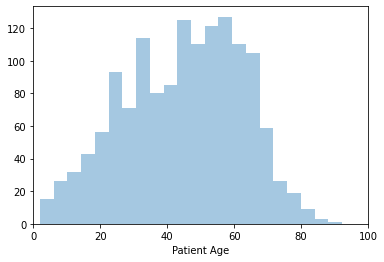

In [18]:
# Pneumonia only
g = sns.distplot(p_xray_df['Patient Age'], bins=100, kde=False)
g.axes.set_xlim(0, 100)
plt.show()

## View position

All positions AP or PA. Whole dataset has bias towards PA, as does pneumonia subset to a much lesser extent.

In [19]:
# Whole ds
all_xray_df['View Position'].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

In [20]:
# Pneumonia only
p_xray_df['View Position'].value_counts()

AP    801
PA    630
Name: View Position, dtype: int64

## Co-occurrence
Among pneumonia cases, infiltration is the most likely diseases to also be seen at around 45% of cases. However, as a stand-alone indicator for pneumonia, edema is by far most likely to imply the presence of pneumonia in this dataset, with over 14% of edema cases also having pnemonia.

In [21]:
# Can calculate co-occurrence with linear algebra
pneumonia_vector = all_xray_df['Pneumonia']
disease_matrix = all_xray_df[all_diseases].to_numpy()
cooccurrence = np.dot(pneumonia_vector, all_xray_df[all_diseases])
#cooccurrence = np.divide(cooccurrence, cooccurrence)

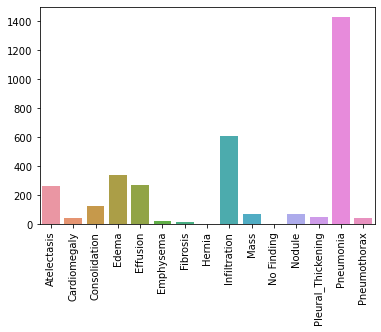

In [22]:
g = sns.barplot(x=all_diseases, y=cooccurrence)
g.set_xticklabels(all_diseases, rotation=90)
plt.show()

In [23]:
# Get rates of pneumonia among different diseases
diseases = []
rates = []
for i, disease in enumerate(all_diseases):
    if disease not in ['Pneumonia', 'No Finding']:
        diseases += [disease]
        rates += [cooccurrence[i] / np.sum(disease_matrix[:, i])]

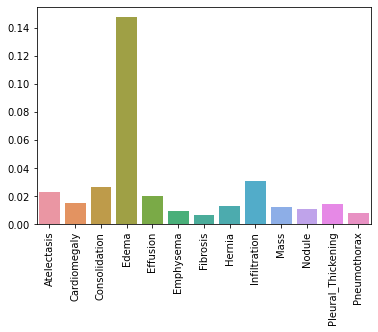

In [24]:
g = sns.barplot(x=diseases, y=rates)
g.set_xticklabels(diseases, rotation=90)
plt.show()

## Metadata conclusions

Images with pneumonia only make up around 1.3% of all first visit images in the dataset so the training set should be balanced accordingly. Removing negative cases randomly until the positive/negative split is about 1:1 would mean the model can't achieve lower loss by being biased towards negative cases. This, however, would make the test set much larger than the training set (assuming an 80/20 initial split) and would not give very useful results (models overly biased toward negative cases would appear to be doing artificially well during training, and a real scenario would likely have more pneumonia cases than this dataset if that is what's being tested for). A less extreme split (e.g. 1:3) would be more helpful in telling us how our model is doing.

There doesn't seem to be a huge shift in age/gender/view position distributions between pneumonia cases and the whole dataset so we do not need to worry too much about them during training. However, edema and infiltration do show correlations with pneumonia so we should check that the training and testing sets have similar proportions of these diseases to avoid misleading results. Many pneumonia patients have repeat visits and are quite likely to have more than one image in this dataset, so we should avoid any one patient having images in both the training and testing sets since in a real scenario it is unlikely that a model will have seen a subject before. Such data leakage would give us inflated performance metrics.

# Pixel-level assessments

In [25]:
# Code below adds full image path to each sample in sample_df

import glob

paths = glob.glob('/data/images_*/**', recursive=True)
paths = [x for x in paths if x[-3:] == 'png']
paths = sorted(paths, key=lambda x : x.split('/')[-1])

images = sorted(sample_df['Image Index'].values.tolist())

i = j = 0
while i < len(images):
    while j < len(paths):
        path_image = paths[j].split('/')[-1]
        if images[i] < path_image:
            i += 1
            break
        elif images[i] > path_image:
            j += 1
            continue
        else:
            sample_df.at[sample_df[sample_df['Image Index'] == images[i]].index[0], 'Image Path'] = paths[j]
            i += 1
            break

In [26]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image Path
3057,00015069_000.png,Infiltration|Pneumonia,0,15069,025Y,M,PA,2048,2500,0.168,0.168,/data/images_007/images/00015069_000.png
5065,00026908_010.png,No Finding,10,26908,064Y,M,AP,3052,2544,0.139,0.139,/data/images_011/images/00026908_010.png
3786,00018607_001.png,Mass,1,18607,064Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00018607_001.png


In [27]:
# One hot encode diseases
for disease in all_diseases:
    sample_df[disease] = sample_df['Finding Labels'].apply(lambda x : int(disease in x))

sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1298,00006794_004.png,Consolidation|Emphysema|Infiltration,4,6794,067Y,M,AP,2500,2048,0.168,...,1,0,0,1,0,0,0,0,0,0
2250,00011558_008.png,No Finding,8,11558,043Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
2337,00011874_000.png,No Finding,0,11874,062Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0


## Compare images across diagnoses
From a direct comparison between pneumonia and non-pneumonia images of the same patient it seems that pneumonia can be characterised by lungs containing a high occurence of high-intensity pixels, which can also been seen through their corresponding histograms. However, looking at the images and intensity histograms of images from different patients (one containing inflitration and one with no disease), it is much harder to identify the diseases present from pixel intensities alone. Normalising the distributions within each image makes this a little easier since different overall brightnesses and variances for each image are ignored (what we really want are relative intensity values within images).

In [28]:
# Get xrays to be explored
eda_samples = pd.DataFrame()

In [29]:
from random import randrange

# Get all patients with pneumonia and non-pneumonia x-rays
p_np_patients = []
for patient_id, group in sample_df.groupby('Patient ID'):
    if (1 in group['Pneumonia'].values) and (0 in group['Pneumonia'].values):
        p_np_patients += [patient_id]
        
eda_samples = eda_samples.append(sample_df[sample_df['Patient ID'] == p_np_patients[randrange(len(p_np_patients))]])

In [30]:
from random import sample

# Get image with both pneumonia and infiltration
p_i_df = sample_df[(sample_df['Pneumonia'] == 1) & (sample_df['Infiltration'] == 1)]
eda_samples = eda_samples.append(p_i_df.iloc[randrange(len(p_i_df))])

# Get image with no disease
nd_df = sample_df[sample_df['No Finding'] == 1]
eda_samples = eda_samples.append(nd_df.iloc[randrange(len(nd_df))])

In [32]:
eda_samples

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2791,00013952_000.png,Atelectasis|Pneumonia,0,13952,059Y,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,0
2792,00013952_003.png,Infiltration,3,13952,059Y,M,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,0
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168,...,0,0,0,1,0,0,1,0,1,0
5383,00029064_000.png,No Finding,0,29064,040Y,F,PA,2544,3056,0.139,...,0,0,0,0,0,1,0,0,0,0


In [50]:
load_image = lambda path : np.asarray(Image.open(path))
eda_images = dict((index, load_image(path)) for index, path 
                  in zip(eda_samples['Image Index'], eda_samples['Image Path']))

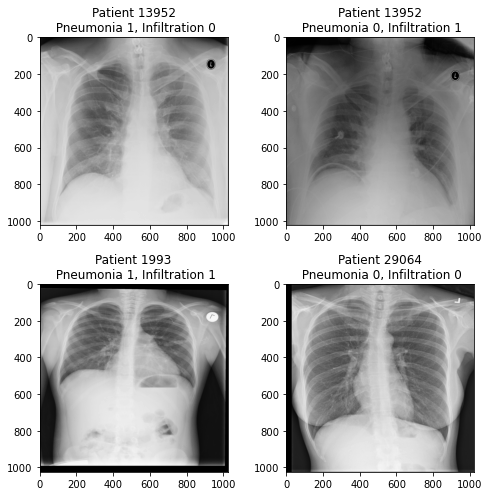

In [51]:
# Visualise xrays
fig, axs = plt.subplots(2, 2, figsize=(7,7))

for i, index in enumerate(eda_images):
    sample = sample_df[sample_df['Image Index'] == index]
    ax = axs.flatten()[i]
    ax.set_title('Patient {}\n Pneumonia {}, Infiltration {}'.format(sample['Patient ID'].iloc[0], 
                                                                    sample['Pneumonia'].iloc[0], 
                                                                    sample['Infiltration'].iloc[0]))
    ax.imshow(eda_images[index], cmap='gray')
plt.tight_layout()

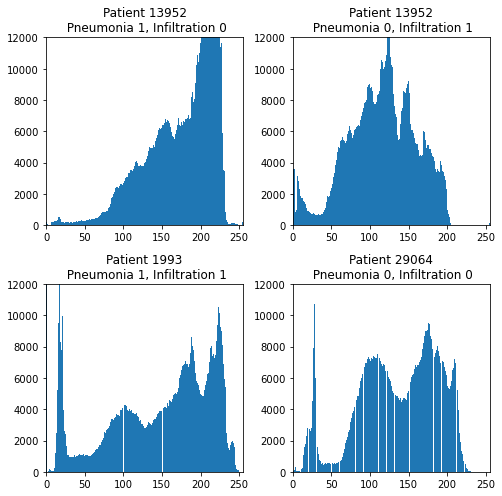

In [52]:
# Plot histograms
fig, axs = plt.subplots(2, len(eda_samples)//2, figsize=(7, 7))

for i, index in enumerate(eda_images):
    sample = sample_df[sample_df['Image Index'] == index]
    ax = axs.flatten()[i]
    ax.set_title('Patient {}\n Pneumonia {}, Infiltration {}'.format(sample['Patient ID'].iloc[0], 
                                                                    sample['Pneumonia'].iloc[0], 
                                                                    sample['Infiltration'].iloc[0]))
    ax.hist(eda_images[index].ravel(), bins=256)
    ax.set_ylim(0, 12000)
    ax.set_xlim(0, 255)
plt.tight_layout()

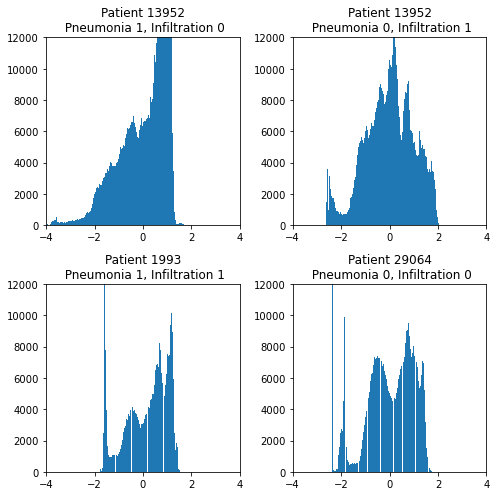

In [68]:
# Plot histograms
fig, axs = plt.subplots(2, len(eda_samples)//2, figsize=(7, 7))

for i, index in enumerate(eda_images):
    sample = sample_df[sample_df['Image Index'] == index]
    ax = axs.flatten()[i]
    ax.set_title('Patient {}\n Pneumonia {}, Infiltration {}'.format(sample['Patient ID'].iloc[0], 
                                                                    sample['Pneumonia'].iloc[0], 
                                                                    sample['Infiltration'].iloc[0]))
    pixels = eda_images[index].ravel()
    norm = (pixels - pixels.mean()) / pixels.std()
    ax.hist(norm, bins=256)
    ax.set_ylim(0, 12000)
    ax.set_xlim(-4, 4)
plt.tight_layout()

## Averaged histograms
Comparing the combination of intensity values for many images in both positive and negative pneumonia cases provides more evidence for the earlier notion that x-rays with pneumonia seem to have spikes at high intensities than those without (see large spike near 250 in pneumonia histogram), at least for the images looked at here. However, individual x-rays may still be hard to distinguish with histograms alone, especially between different patients.

In [64]:
# Take sum of histograms for many (a) pneumonia and (b) non-pneumonia patients and compare
n = 30

np_vals = []
for i, path in enumerate(sample_df[sample_df['Pneumonia'] == 0]['Image Path']):
    if i == n:
        print('Limit reached')
        break
    np_vals = np.concatenate((np_vals, load_image(path).ravel()))
print(len(np_vals))

p_vals = []
for i, path in enumerate(sample_df[sample_df['Pneumonia'] == 1]['Image Path']):
    if i == n:
        print('Limit reached')
        break
    p_vals = np.concatenate((p_vals, load_image(path).ravel()))
print(len(p_vals))

Limit reached
37748736
Limit reached
34603008


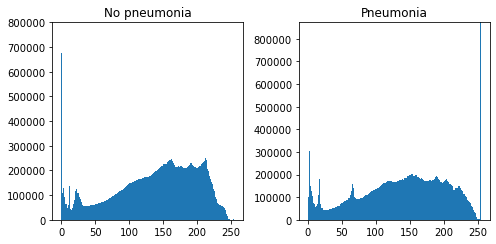

In [65]:
# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))

ax1_height = 0.8e6
ax1.hist(np_vals, bins=256)
ax1.set_title('No pneumonia')
ax1.set_ylim(0, ax1_height)

ax2.hist(p_vals, bins=256)
ax2.set_title('Pneumonia')
ax2.set_ylim(0, ax1_height * len(np_vals) / len(p_vals))

plt.tight_layout()

## Regions of interest
By looking at different regions of interest within one image (with a positive pneumonia diagnosis), we can see that the left lung has a much higher occurrence of high intensity pixels (due to pneumonia) than the right lung (due to the presence of air). Thus, although diagnoses may be difficult to make from histograms alone, they could be easier to make using the intensity distributions within smaller areas, making CNNs a viable option.

In [76]:
np.asarray(Image.open('/data/images_010/images/00022877_014.png')).shape

(1024, 1024)

In [77]:
np.asarray(Image.open('/data/images_010/images/00022877_014.png').resize((224, 224))).shape

(224, 224)

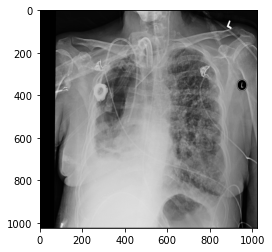

In [60]:
# Load image of patient with pneumonia
img_p = load_image('/data/images_010/images/00022877_014.png')
plt.imshow(img_p, cmap='gray')

In [61]:
# Left lung
ll_y = [210, 800]
ll_x = [300, 400]
left_lung = img_p[ll_y[0]:ll_y[1], ll_x[0]:ll_x[1]]

# Right lung
rl_y = [200, 800]
rl_x = [650, 820]
right_lung = img_p[rl_y[0]:rl_y[1], rl_x[0]:rl_x[1]]

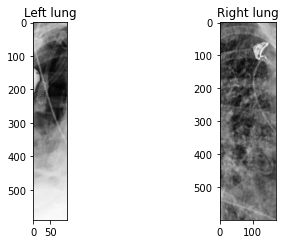

In [62]:
# Visualise left and right lungs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))

ax1.imshow(left_lung, cmap='gray')
ax1.set_title('Left lung')

ax2.imshow(right_lung, cmap='gray')
ax2.set_title('Right lung')

plt.tight_layout()

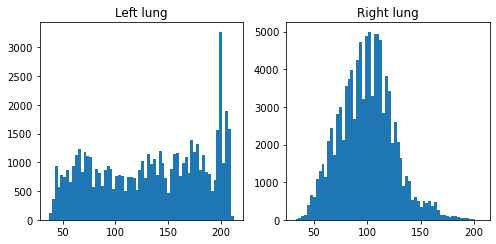

In [63]:
# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))

ax1.hist(left_lung.ravel(), bins=64)
ax1.set_title('Left lung')

ax2.hist(right_lung.ravel(), bins=64)
ax2.set_title('Right lung')

plt.tight_layout()

## Pixel-level assessments conclusions
We can see that pneumonia generally leads to a higher frequency of high-intensity pixel values in the lungs. However, since not all x-rays will have a healthy x-ray of the same individual for comparison, histograms may not always carry enough information to make a diagnosis. CNNs, however, are able to look at intensity distributions within smaller regions of interest and are thus more suitable for this task.

All of the sample images looked at here had intensity values in the [0,255] range. Samplewise normalisation makes the *relative* pixel intensities more important within images, and also helps to avoid the vanishing/exploding gradient problem for deep neural networks. This should be implemented in model development.